In [1]:

from collections import OrderedDict
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim

pygame 2.5.2 (SDL 2.28.3, Python 3.11.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
from config import get_config
from minigrid_environments import EmptyEnv_random_goal
from data_collection import collect_data_from_env
from networks import Maml_agent
from utils import  Logs_and_stats
from loss import policy_loss


In [3]:
#configs
config_setting='custom'
config=get_config(config_setting)




In [4]:
# Simple minigrid environment
def sample_env(size,max_steps):
    env = EmptyEnv_random_goal(size=size,max_steps=max_steps)
    env = gym.wrappers.RecordEpisodeStatistics(env)
    return env

env=sample_env(size=config.env_size ,max_steps=config.max_episode_length)



In [5]:
agent = Maml_agent(env)
meta_optimizer = optim.Adam(agent.parameters(), lr=config.meta_lr, eps=1e-5)
logger=Logs_and_stats()


In [6]:
def inner_loop(agent_model, env , logger ,config):

    updated_params=OrderedDict(agent_model.named_parameters()) # base parameters

    # ADAPTATION - K gradient steps
    # for each adaptation step : collect data with current policy (starting with the base policy) for doing the inner loop adaptation. Use this data to
    # Compute gradient of the tasks's policy objective function  with respect to the current policy parameters.
    # finally use this gradient to update the parameters. Repeat the process config.num_adaptation_steps times .
    for i in range(config.num_adaptation_steps):
        buffer, mean_episode_return =collect_data_from_env(agent=agent,params=updated_params ,env=env, num_steps=config.env_steps_to_estimate_loss,logger=logger,config=config)
        if (i==0):
            logger.base_policy_episode_returns.append(mean_episode_return)
        il_loss = policy_loss(agent=agent,params=updated_params, buffer=buffer)

        grads = torch.autograd.grad(il_loss, updated_params.values(),
                                    create_graph=True)
        
        for (name, param), grad in zip(updated_params.items(), grads):
            updated_params[name] = param - config.il_lr * grad

    #META LOSS CALCULATION
    #collect data with adapted policy and calculate loss (policy objective evaluated at the adapted params) for the outer loop update .
    buffer,mean_episode_return =collect_data_from_env(agent=agent,params=updated_params ,env=env, num_steps=config.env_steps_to_estimate_loss,logger=logger,config=config)
    logger.adapted_policies_episode_returns.append(mean_episode_return)
    ol_loss  = policy_loss(agent=agent,params=updated_params ,buffer=buffer)

    return ol_loss

In [7]:
def outer_loop():

    for i in range(config.num_meta_updates):
        meta_loss=0
        envs=[sample_env(size=config.env_size ,max_steps=config.max_episode_length) for _ in range(config.num_tasks_per_meta_update)]
        for env in envs:
            meta_loss+= inner_loop(agent_model=agent, env=env, logger=logger ,config=config)
        
        logger.update_statistics()
        meta_optimizer.zero_grad()
        meta_loss.backward()
        meta_optimizer.step()
        
        if i%10==0:
            print(f'completed meta update {i} -> adapted return= {np.mean(logger.adapted_policies_episode_returns[-config.num_tasks_per_meta_update:])} , base return={np.mean(logger.base_policy_episode_returns[-config.num_tasks_per_meta_update:])}')




In [ ]:
outer_loop()

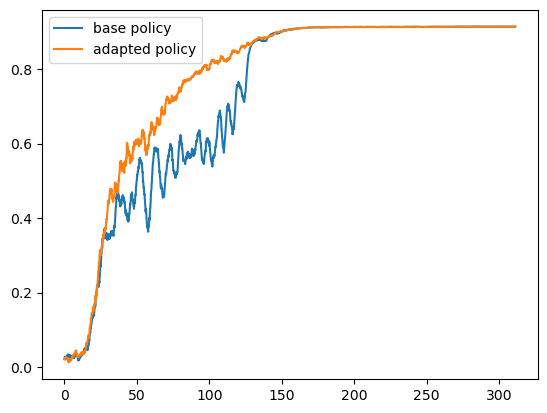

In [9]:
#Plot the mean return obtained per episode

window_size = 20 
base_policy_returns = np.convolve(np.array(logger.base_policy_episode_returns), np.ones(window_size), 'valid') / window_size
adapted_policy_returns = np.convolve(np.array(logger.adapted_policies_episode_returns), np.ones(window_size), 'valid') / window_size
x_axis=np.arange(0,len(base_policy_returns))/config.num_tasks_per_meta_update
x_axis2=np.arange(0,len(adapted_policy_returns)) /config.num_tasks_per_meta_update
plt.plot(x_axis,base_policy_returns ,label='base policy' )
plt.plot(x_axis2,adapted_policy_returns ,label='adapted policy' )
plt.legend()

### evaluation

In [ ]:
def evaluation(agent, env, num_evaluation_steps, num_adaptation_updates,logger ):
    updated_params=OrderedDict(agent.named_parameters())
    for i in range(num_adaptation_updates):

        buffer, mean_episode_return =collect_data_from_env(agent=agent,params=updated_params ,env=env, num_steps=config.env_steps_to_estimate_loss, logger=logger,config=config)
        adaptation_loss  = policy_loss(agent=agent,params=updated_params, buffer=buffer)

        grads = torch.autograd.grad(adaptation_loss, updated_params.values(),
                                    create_graph=True)

        for (name, param), grad in zip(updated_params.items(), grads):
            updated_params[name] = param - config.il_lr * grad

    buffer,mean_episode_return =collect_data_from_env(agent=agent,params=updated_params ,env=env, num_steps=num_evaluation_steps, logger=logger,config=config)
    
    return mean_episode_return

In [ ]:
#evaluate performance with different numbers of adaptation steps

env=sample_env(size=config.env_size ,max_steps=config.max_episode_length)

num_evaluation_steps= 20000
nums_adaptation_updates=[0,1,3 ,5]
loggers=[Logs_and_stats() for i in range(len(nums_adaptation_updates))]
for l in loggers:
    l.rewards_mean=logger.rewards_mean



for logger, num_adaptation_updates in zip(loggers,nums_adaptation_updates):
    mean_episode_return=evaluation(agent=agent,env=env, num_evaluation_steps=num_evaluation_steps, num_adaptation_updates=num_adaptation_updates ,logger=logger)

    print(f'num adaptation steps= {num_adaptation_updates} -> mean episodic return of {mean_episode_return}')

